<h1>Assign 1 - Deep Learning</h1>
Jonathan Menahem - 203772611 <br>
Alon Mazri - 

Help Source: [https://www.analyticsvidhya.com/blog/2020/09/pneumonia-detection-using-cnn-with-implementation-in-python/](https://www.analyticsvidhya.com/blog/2020/09/pneumonia-detection-using-cnn-with-implementation-in-python/)

In [3]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten

<h2>Loading The Data</h2>

In [72]:
# importing the data into variables

def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))

    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    
    return norm_images, norm_labels

def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    
    return pneu_images, pneu_labels 

In [73]:
norm_images, norm_labels = load_normal("chest_xray\\train\\NORMAL\\")
pneu_images, pneu_labels = load_pneumonia("chest_xray\\train\\PNEUMONIA\\")

100%|██████████| 3875/3875 [00:22<00:00, 171.49it/s]


In [83]:
X_train = np.append(norm_images, pneu_images, axis=0)
y_train = np.append(norm_labels, pneu_labels)

In [84]:
np.unique(y_train, return_counts=True)

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2530, 1341, 1345], dtype=int64))

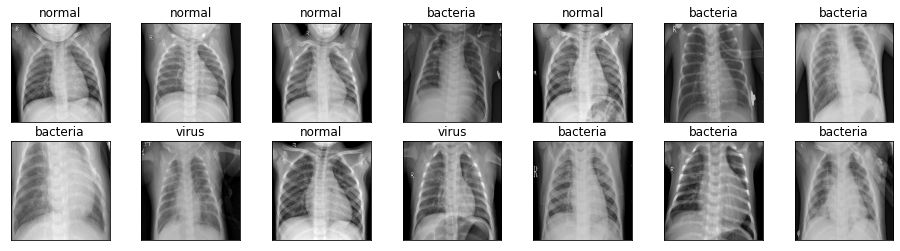

In [85]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(X_train), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

In [86]:
norm_images_val, norm_labels_val = load_normal("chest_xray\\val\\NORMAL\\")
pneu_images_val, pneu_labels_val = load_pneumonia("chest_xray\\val\\PNEUMONIA\\")
X_val = np.append(norm_images_val, pneu_images_val, axis=0)
y_val = np.append(norm_labels_val, pneu_labels_val)

100%|██████████| 8/8 [00:00<00:00, 186.55it/s]


In [87]:
norm_images_test, norm_labels_test = load_normal("chest_xray\\test\\NORMAL\\")
pneu_images_test, pneu_labels_test = load_pneumonia("chest_xray\\test\\PNEUMONIA\\")
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

100%|██████████| 390/390 [00:01<00:00, 198.40it/s]


In [88]:
y_train = y_train[:, np.newaxis]
y_val = y_val[:, np.newaxis]
y_test = y_test[:, np.newaxis]

one_hot_encoder = OneHotEncoder(sparse=False)

y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_val_one_hot = one_hot_encoder.transform(y_val)
y_test_one_hot = one_hot_encoder.transform(y_test)


In [89]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [90]:
#testing the new shape of our data:

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5216, 200, 200, 1)
(16, 200, 200, 1)
(624, 200, 200, 1)


<h2>Building The Model</h2>